# **Algorithmic Methods for Data Mining: Homework 4**

**Author:** Miguel Angel Sanchez Cortes

*MSc. in Data Science, Sapienza University of Rome*

---

## **0. Uploading the Classes and Modules**

Before doing any kind of analysis it is necessary to upload both the relevant Classes and Modules we will use to work.

In [30]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from modules.cluster import FAMD, KMeans, KMeansPlusPlus
from modules.data_handler import DataHandler
from modules.recommender import Recommender
from sklearn.cluster import BisectingKMeans
from modules.plotter import Plotter
import pandas as pd
import numpy as np
import time


---

## **1. Recommendation System**

In this homework, we were asked to implement our version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input a user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

### **1.1. The Dataset**

We were provided with a [dataset](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies) that provides anonymised movie watch history of opted-in Netflix users in the United Kingdom. We can observe the structure of this dataset below:

In [20]:
#Here we open the csv file with pandas and create a dataframe. The first column is the index
raw_dataset = pd.read_csv('data/vodclickstream_uk_movies.csv', index_col=0).reset_index(drop=True)

#Here we print the first 5 rows of the dataframe
raw_dataset.head()


,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


This dataset (according to its Kaggle description):

> Covers user behaviour on Netflix from users in the UK to opted-in to have their anonymized browsing activity tracked. It only includes desktop and laptop activity (which Netflix estimate is around 25% of global traffic) and is for a fixed window of time (January 2017 to June 2019, inclusive). It documents each time someone in our tracked panel in the UK clicked on a Netflix.com/watch URL for a movie.

The columns are described as follows:

- **datetime**: Date and time of the click.

- **duration**: Time between this click and the user's next tracked click on Netflix.com, in seconds. A watch time of zero seconds means they visited the page but instantly clicked away.

- **title**: Movie title.

- **genres**: Movie genre(s).

- **release_date**: Movie's original theatrical release date (not when it first appeared on Netflix).

- **movie_id**: VODC title ID.

- **user_id**: VODC user ID.

From the raw dataset we noticed a few things we can approach before doing any kind of analysis:

1. There are **negative** values on the **duration** column and this can't be possible since time cannot be negative. Therefore we filtered out rows with these values.

2. There are "NOT AVAILABLE" values on the **genres** and **release_date** fields. These are clearly not categories or dates and therefore we need to substitute them with `NaN`.

3. There exist movies with the same title but **different** values for the **genres** and **release_date** fields. This cannot be possible since movies that are have the same name should be the same movie. Therefore, we decided to substitute the **genre** and **release_date** values of each movie that have the same name with the **mode** of the values between those movies.

    In this way we can ensure that we have the correct values for the **genres** and **release_date** fields. Of course if the values are all `NaN`, they still remain in that way.

We can solve these issues using the custom-made `DataHandler` class we built specifically for this homework. For more information on the **implementation** of the code behind it, please refer to the `data_handler.py` file included in the `modules` folder of this repository.

Initializing the `DataHandler` class:

In [21]:
#Here we create a DataHandler object that will be used to clean the data
data_handler = DataHandler(raw_dataset)

#Here we can print the cleaned dataframe
data_handler.cleaned_data.head()


,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


Now we have our dataset cleaned and ready for exploration. We can obtain general information of the dataset:

In [4]:
#Here we print the info of the dataframe
data_handler.cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650002 entries, 0 to 650001
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      650002 non-null  datetime64[ns]
 1   duration      650002 non-null  float64       
 2   title         650002 non-null  object        
 3   genres        633484 non-null  object        
 4   release_date  629873 non-null  datetime64[ns]
 5   movie_id      650002 non-null  object        
 6   user_id       650002 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 34.7+ MB


As we can see, we still have `NaN` values on the **genres** and **release_date** columns. Nevertheless we will deal with that later on since we don't really have to change this in this section. Another important thing we can notice is that when cleaning the dataset we converted the type columns in a convenient way for us to handle them. The dates are now of `datetime` type and the duration is a `float64`.

Now, as a first task, we were asked to gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks. We can do this by means of our `DataHandler` class:

In [5]:
#Here we print the dataset that contains the maximum top 10 movies for each user regarding number of clicks
data_handler.lsh_user_data.head()


,user_id,title,genres,clicks
0,00004e2862,Hannibal,"Crime, Drama, Thriller",1
1,000052a0a0,Looper,"Action, Drama, Sci-Fi, Thriller",9
2,000052a0a0,Frailty,"Crime, Drama, Thriller",3
3,000052a0a0,Jumanji,"Adventure, Comedy, Family, Fantasy",3
4,000052a0a0,Resident Evil,"Action, Horror, Sci-Fi",2


As we can see, now we have converted our data in a user-based dataset containing the top-10 movies a user clicked on regarding number of clicks. We have to notice of course that if a user didn't click on more than 10 movies, we will have less movies for that particular user.

One important thing to notice is that this dataset doesn't contain `NaN` values as we can see from its information:

In [6]:
#Here we print the info of the dataset
data_handler.lsh_user_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419403 entries, 0 to 419402
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  419403 non-null  object
 1   title    419403 non-null  object
 2   genres   419403 non-null  object
 3   clicks   419403 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 12.8+ MB


### **1.2. Minhash Signatures**

As a next step, we were asked to use the **movie genre** and **user_ids** to try to implement min-hash signatures in order that users with similar interests in a genre appear in the same bucket. To do this we used the custom-made `Recommender` class we built specifically for this homework. For more information on the **implementation** of the code behind it, please refer to the `recommender.py` file included in the `modules` folder of this repository.

We can initialize our class:

In [7]:
#Here we create a Recommender object that will be used to create the model
recommender = Recommender(data_handler.lsh_user_data)


Now, in order to perform Minhashing, we must perform the following steps:

#### **1.2.1. Shingling**

In this case we define each different **genre** as a shingle and represent our users as sets of shingles. Shingles can be categories or characters that represent a document. 

For example, we can represent a user A as:

$$A = \{\text{drama}, \text{horror}, \text{mystery}, \dots\},$$

the set of genres the user clicked the most (in the context of the top-10 movies regarding clicks).

We can obtain the shingles from every user in our dataset via our `Recommender` class. As an example, we can see that we can represent user `82af209598` by its shingles as follows:

In [8]:
#Here we can see an example of the shingles of the user with id '82af209598'
recommender.genres_by_user['82af209598']


['sci-fi',
 'comedy',
 'fantasy',
 'animation',
 'action',
 'adventure',
 'thriller',
 'crime',
 'family']

Here we can see that among its top 10 most clicked movies, user `82af209598` had movies with the genres obtained before. This is a first way of knowing which kind of movies the user likes. We can do this for every user and represent each individual user as the genres it clicked on. Nevertheless in order to be able to compare each user we must have a way to represent each user regardless of the order in which each genre appears.

#### **1.2.2. Building the Characteristic Matrix**

Once we've represented each of our users using its genre shingles, we can build the *characteristic matrix* of users. The columns of this matrix correspond to each unique user and the rows correspond to elements of the universal set of shingles (in this case the universal set of genres) from which elements are drawn. 

There is a 1 in the element $(i,j)$ of the matrix if the genre of row $i$ has been watched by user $j$. In general, we have the following matrix:

<br>
    
\begin{equation*}
\begin{pmatrix}
& \text{User 1}&\text{User 2}&\dots&\text{User $n-1$}&\text{User $n$}\\
\text{action} &1&0&\dots&0&1\\
\text{adventure} &0&0&\dots&1&0\\
\vdots &0&1&\dots&0&1\\
\text{war} &1&0&\dots&1&1\\
\text{western} &0&0&\dots&1&0
\end{pmatrix}
\end{equation*}

<br>

As we can see, the first row represents the **action** genre and we can see that users $1$ and $n$ have frequently clicked movies on this genre. The same applies for the other rows. We can think of this matrix as being formed by the **one-hot representation** of users regarding the genres they most frequently clicked.

For completeness, we can obtain the column of these matrix for our dummy user `82af209598`:

In [9]:
#Here we obtain the one-hot representation of the shingles of the user with id '82af209598'
recommender.characteristic_matrix.T[recommender.users['82af209598']]


array([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0.])

As we can see, we only have $1$ values in 9 indexes representing the 9 genres the user most frequently clicked. As we already know, these genres are: action, adventure, animation, comedy, crime, family, fantasy, sci-fi, and thriller (in that order).

We can use this representation to compare users depending on their genres. Nevertheless, when the number of users and shingles grows this becomes a problem. We can therefore replace this large matrix with a smaller (it also can be longer depending on the number of unique shingles of our dataset) "signature" that still preserves the underlying similarity between users. 

#### **1.2.3. Min-Hashing**

We can do this by building a **signature matrix** via **Min-Hashing**. In order to create this matrix from the characteristic matrix we need to:

1. Randomly permute the rows of the characteristic matrix. E.g. Rows 12345 => 35421, so if "drama" was in row 1, it would now be in row 5.
    
    2. For each user, start from the top and find the position of the first shingle that appears in the set, i.e. the first shingle with a 1 in its cell. Use this shingle number to represent the set. This is the "signature".

    3. Repeat as many times as desired, each time appending the result to the set's signature.

In practice doing permutations is very costly and therefore we use **hash functions** in order to mimic these permutations. The definition of a hash function which takes an input integer $x$ is:

$$h(x) = ax + b \text{ mod $c$}$$

The coefficients $a$ and $b$ are normally chosen as random integers less than the number of rows of the shingle matrix and the $c$ value is a **prime** number slightly bigger than the number of rows.

Therefore, instead of permuting the rows of the characteristic matrix, we apply a random hash function. It is important to notice that applying this function is not necessarily a true permutation since there can be collisions, where two rows have the same hash value. This depends on the choice of $c$ and the number of rows.

Using this framework, our algorithm transforms to the following:

1. Initially, we set all the values of the signature matrix to $S(i,c)=\infty$.

2. For each row, we compute $h_{1}(r), h_{2}(r), \dots, h_{n}(r)$ $n$ random hash functions.

3. For each column $c$ of row $r$:

    - If $c$ has 0 in row $r$, we do nothing.

    - If $c$ has 1 in row $r$, then for each $i\in\{1,\dots, n\}$ we set $S(i,c)$ to be the **smaller** of the current value of $S(i,c)$ and $h_{i}(r)$.


This matrix will have as dimension the number of hash functions (or permutations) we decide to perform on our rows by the number of users. The choice of the number of hash functions to use depends on the nature of each problem and will be discussed in more detail in the next subsection.

For our Recommendation System we chose **100 hash functions** and therefore the dimension of our matrix is:

In [10]:
#Here we obtain the shape of the signature matrix
recommender.signature_matrix.shape


(100, 152185)

Through this method, we produce vectors of equal length that contain positive integer values in the range of $(1, \text{\# of shingles})$, these are called the signatures of each user. Now, in principle, we would like to hash our users to **buckets** in a way that similar users finish together in the same bucket. Nevertheless, if we were to hash each of the users taking all its signature as a whole we may struggle in finding similar users since they would have to be **exactly** equal to be hashed to the same buckets.

In most cases, even though parts of two vectors may match perfectly, we would likely hash them into separate buckets. We don’t want this. We want signatures that share even some similarity to be hashed into the same bucket, this is why we perform **banding**.

#### **1.2.4. Banding and Bucketing**

The banding method solves this problem by splitting our vectors into sub-vectors called *bands*. Then, rather than hashing a user to a bucket by taking into account its whole signature vector, we do this by taking into account only a part of this vector. For example, if we split a 100-dimensionality vector into 20 bands, this gives us 20 opportunities to identify matching sub-vectors between our vectors.

This, of course, increases the number of false positives (users that were hashed into the same bucket but are not similar). Nevertheless, we can tune this by noting that the probability of a pair of users being hashed to the same bucket given they have a similarity score $s$ is given by:

\begin{equation*}
\mathbb{P} = 1 - (1-s^{r})^{b},
\end{equation*}

where $b$ is the number of bands we divided our signature vectors on and $r$ the number of rows per band. By similarity we mean the **Jaccard Similarity** between the users (in this case, between the genres watched by each user).  We can plot this probability using our custom-made `Plotter` class (for information about the implementation refer to the `plotter.py` file in the modules folder of our repository) for different values of banding $b$:

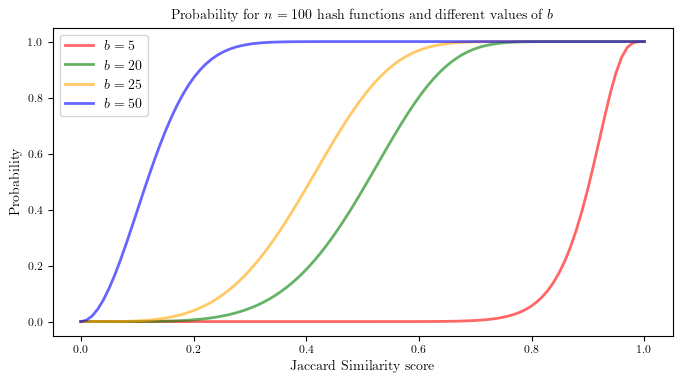

In [4]:
#Here we plot the probability of a pair of users being hashed to the same bucket in function of their similarity
Plotter().plot_probability()


As we can see, as the value of $b$ increases, so does the number of false positives. This is expected since when we increase the number of bands we decrease the number of rows $r$ we need to take into account to hash our users to their buckets and therefore we are more flexible when considering two users as "similar". On the other way, if we decrease the number of bands, we consider more rows when comparing users and therefore it is more probable to hash to the same bucket users with high similarity score.

In order to not be very restrictive with our banding, we considered a value of $b=20$ for our exercise, giving a value of $r=5$ since we used **100** hash functions.

Finally, once we've chosen our values for banding, we need to hash users that have the same signature in each band to the same bucket. We also have to make sure that users that have the same signature but on different bands are not hashed to the same bucket. This is why we decided to hash each user in the following way:

> Users were hashed to the bucket with `bucket_id` equal to their signature. In addition these buckets are also identified by the band in which the signature took place. In this way, users are not only hashed by their signature but also by the **band** in which the user had that signature. For example, if a user had the signature `5403834` on band `3` it would be hashed to the bucket with `bucket_id` equal to `5403834` but with the restriction that this bucket only allows signatures from band $3$. 

In this way we made sure that users that have the same signature are hashed to the same bucket **only** if the signature is the same on the same band. 

### **1.3. Locality-Sensitive Hashing (LSH)**

Now that our buckets are ready, we can start getting recommendations. Our goal is to recommend at most five movies to a user with a given `user_id`. We used the following procedure:

1. We extracted the **two** most similar users to our target user. We did this by following these steps:

    * We performed Min-Hashing on the one-hot vector representation of our target user.
    
    * Based on its signature vector, we obtained all the users that shared at least once a bucket with our target user for any band.

    * We found the two top users who shared buckets with our target user the **greatest** number of times. We did this by mantaining the similar users on a `heap` structure.

2. If these two users had any movies in common, we recommended those movies based on the **total** number of clicks by these users.

3. If there were no more common movies, we tried to propose the most clicked movies by the most similar user first, followed by the other user.

In the end we obtained at most 5 movie recommendations. For example, if we try our Recommendation System for our dummy user `82af209598` we obtain:

In [12]:
#Here we obtain 5 movies recommended for the user with id '82af209598'
recommender.get_recommendations('82af209598')


,Recommended Movies for User 82af209598
1,Kick-Ass 2
2,The Last Airbender
3,Back to the Future
4,Cloudy with a Chance of Meatballs 2
5,Godzilla


From these recommendations we can see in fact that there are a lot of animated/action/fantasy movies, which is consistent to the genres our user usually likes. We essentially can obtain recommendations for each user in our dataset. We can try even to get recommendations for a user at random:

In [22]:
#Here we obtain 5 movies recommended for the user with random id
recommender.get_recommendations(random=True)


,Recommended Movies for User 2086196cc7
1,Mudbound
2,Their Finest
3,To All the Boys I've Loved Before


**References for this section:**

1. Leskovec, J., Rajaraman, A.,, Ullman, J. D. (2014). [Mining of Massive Datasets](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf). Cambridge University Press.

2. [Building a Recommendation Engine with Locality-Sensitive Hashing (LSH) in Python](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/).

3. [Locality Sensitive Hashing: How to Find Similar Items in a Large Set, with Precision](https://towardsdatascience.com/locality-sensitive-hashing-how-to-find-similar-items-in-a-large-set-with-precision-d907c52b05fc).

4. [Similarity Search, Part 5: Locality Sensitive Hashing (LSH)](https://towardsdatascience.com/similarity-search-part-5-locality-sensitive-hashing-lsh-76ae4b388203).

5. [Locality Sensitive Hashing (LSH): The Illustrated Guide](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/).

---

## **2. Grouping Users Together!**

Now, we will deal with clustering algorithms in order to provide groups of Netflix users that are similar among. As we can see, our dataset has information about **clicks** made on movies by certain users. Nevertheless it doesn't contain explicit information about the users themselves, this is why we need to perform **Feature Engineering** before doing any kind of clustering.

### **2.1. Feature Engineering**

In order to obtain relevant data **by user** in our dataset, we obtained the following features (as suggested by the homework statement):

1. **Favorite Genre** (`favourite_genre`): To obtain this feature we grouped our dataset by user and for each user we obtained the genre in which the user spent more time i.e. the genre in which the total duration of clicks was higher.

2. **Average Click Duration** (`avg_click_duration`): To obtain this feature we simply grouped our dataset by user and obtained the average value of the click duration for each user.

3. **Most Active Time of Day (Morning/Afternoon/Night)** (`most_active_time_day`): To obtain this feature we grouped our dataset by user and for each user we classified each of its clicks using the following rule:

    * If the click was made between 4:00 a.m. and 11:59 p.m. it is classified as **Morning**.

    * If the click was made between 12:00 p.m. and 19:59 p.m. it is classified as **Afternoon**.

    * If the click was made between 20:00 p.m. and 3:59 a.m. it is classified as **Night**.

    Then, after doing this, we obtained the time in which the user spent more time i.e. the time in which the total duration of clicks was higher.

4. **Old Movie Lover** (`is_old_movie_lover`): To obtain this feature we grouped our dataset by user and for each user we classified the movie it clicked on in the following way:

    * If the movie's release date was **before or in** 2010, we classify it as an **Old Movie**.

    * If the movie's release date was **after** 2010, we classify it as **Not an Old Movie**.

        Then, after doing this, we obtained the type of movie in which the user spent more time i.e. the  type of movie in which the total duration of clicks was higher.

5. **Average time spent a day by the user** (`avg_time_per_day`): To obtain this feature we simply grouped our dataset by user and date (in format YYYY-MM-DD, not timestamp) and obtained the average value of the click duration taking into account only the days the user logged-in.

The goal of this section was to obtain **at least** 15 new features by user, so we performed a prompt to ChatGPT in order for it to suggest to us more features we could obtain from our dataset. Since ChatGPT's answers sometimes were not useful or proposed things out of scope, we had to perform the prompt several times by changing parts of the prompt and chose the most reasonable features. For the sake of tidyness in our Notebook we will just include the list of the **final** suggested features (including our own suggestions) we will obtain from our dataset:

6. **Most Active Time of the Week (Weekend/Weekday)** (`most_active_time_week`): To obtain this feature we grouped our data by user and classified each of its clicks by the following rule:

    * If the click was made on Monday, Tuesday, Wednesday or Thursday it is classified as a **Weekday**.

    * If the click was made on Friday, Saturday or Sunday, it is classified as a **Weekend**.

    Then, after doing this, we obtained the time of the week in which the user spent more time i.e. the time of the week in which the total duration of clicks was higher (weekend or weekday).

7. **Most Active Season of the Year** (`most_active_season`): To obtain this feature we grouped our data by user and classified each of its clicks by the following rule:

    * If the click was made on December, January or February it is classified as **Winter**.

    * If the click was made on March, April or May it is classified as **Spring**.

    * If the click was made on June, July or August it is classified as **Summer**.

    * If the click was made on September, October or November it is classified as **Autumn**.

    Then, after doing this, we obtained the season of the year in which the user spent more time i.e. the season of the year in which the total duration of clicks was higher. It is important to note that since we're working from a dataset from the UK, the seasons are the same for all of our users and we can do this without overcomplicating things.

8. **Genre Diversity** (`genre_diversity`): To obtain this feature we grouped our data by user and obtained the ratio between the number of different genres watched by the user and the total different genres included in our dataset.

9. **Follow-Through-Probability (FTP)** (`ft_probability`): To obtain this feature we grouped our data by user and obtained the ratio between the number of clicks that had duration greater than a **follow-through threshold** (in our case, we decided 10 minutes) and the total number of clicks. This gives us the probability that a user clicks on a movie and stays to watch.

10. **Most Frequent Click Duration** (`most_common_click_length`): To obtain this feature we grouped our data by user and classified each of its clicks by the following rule:

    * If the click duration was under **10 minutes** it was a **Short** click.

    * If the click duration was between **10 minutes** and **1 hour** it was a **Medium** click.

    * If the click duration was longer than **1 hour** it was a **Long** click.

    Then, after doing this, we obtained the **most frequent** click duration for our users. This could give us insight about the engagement of the user on the platform.

11. **Peak Hour Avg. Click Duration** (`mean_duration_peak_hour`): To obtain this feature we grouped our data by user and classified each click by the following rule:

    * If the click was made between 6 p.m. and 11 p.m. it was made during **Peak Hours**.

    * If the click was not made between that period, it wasn't made during a **Peak Hour**.

    Then, after doing this, we obtained the **average click duration** of users during peak hours in order to get insight about the users watching patterns.

12. **Most Active Moment (Nighttime/Daytime)** (`most_active_daytime`): To obtain this feature we grouped our dataset by user and for each user we classified each of its clicks using the following rule:

    * If the click was made between 6:00 a.m. and 17:59 p.m. it is classified as **Daytime**.

    * If the click was made between 18:00 p.m. and 5:59 a.m. it is classified as **Nighttime**.

    Then, after doing this, we obtained the time in which the user spent more time i.e. the time in which the total duration of clicks was higher. It is important to note this is a variation of feature 3 without taking into account the afternoon in order to understand if users are more active during the night or day.

13. **Total Time Spent on Netflix** (`total_time_spent`): To obtain this feature we simply grouped our dataset by user and for each user we obtained the total click duration.

14. **Consistency Ratio** (`consistency_ratio`): To obtain this feature we simply grouped our dataset by user and obtained the **ratio** between the different days the user logged in to Netflix and the total different days considered in our dataset. This gives us a measure of how consistent was a user during the period of time the data was obtained from.

15. **Average Click per Movie** (`avg_click_per_movie`): To obtain this feature we simply grouped our dataset by user and for each user we obtained the average of the clicks made by movie.

Once we obtained all **15** user-based features from our dataset, we end up with a new dataset for `154388` different users. We can observe this new dataset using our `DataHandler` class initialized earlier:

In [5]:
#Here we print our new user-dataset with all the 15 engineered features
data_handler.clustering_data.head()


,favourite_genre,avg_click_duration,most_active_time_day,is_old_movie_lover,avg_time_per_day,most_active_time_week,most_active_season,genre_diversity,ft_probability,most_common_click_length,mean_duration_peak_hour,most_active_daytime,total_time_spent,consistency_ratio,avg_click_per_movie
user_id,,,,,,,,,,,,,,,
322abe045c,Drama,1.513406e+06,Morning,True,1.765640e+06,Weekday,Spring,0.346154,0.571429,Long,NaN,Daytime,21187685.0,0.013172,2.333333
28afa6a44d,Mystery,7.003762e+06,Night,False,1.400752e+07,Weekday,Winter,0.153846,0.500000,Long,7003762.0,Nighttime,14007524.0,0.001098,2.000000
ea2b1ea81e,Musical,1.147194e+07,Night,False,1.147194e+07,Weekday,Winter,0.038462,1.000000,Long,11471935.0,Nighttime,11471935.0,0.001098,1.000000
2863be3386,Comedy,2.223648e+06,Night,True,2.223648e+06,Weekday,Summer,0.423077,0.600000,Long,0.0,Nighttime,11118242.0,0.005488,1.000000
783526abee,Drama,2.530067e+06,Afternoon,False,2.530067e+06,Weekday,Summer,0.384615,1.000000,Long,2878002.0,Nighttime,10120269.0,0.004391,1.000000


We can also print the information of our new dataset to understand its overall structure:

In [7]:
#Here we print the info of our new user-dataset
data_handler.clustering_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 154388 entries, 322abe045c to 7dd5c2ca5c
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   favourite_genre           150302 non-null  object 
 1   avg_click_duration        154388 non-null  float64
 2   most_active_time_day      154388 non-null  object 
 3   is_old_movie_lover        151801 non-null  object 
 4   avg_time_per_day          154388 non-null  float64
 5   most_active_time_week     154388 non-null  object 
 6   most_active_season        154388 non-null  object 
 7   genre_diversity           152185 non-null  float64
 8   ft_probability            154388 non-null  float64
 9   most_common_click_length  154388 non-null  object 
 10  mean_duration_peak_hour   110084 non-null  float64
 11  most_active_daytime       154388 non-null  object 
 12  total_time_spent          154388 non-null  float64
 13  consistency_ratio         154388 non

As a first issue we can see we have several features with `NaN` values. Since we intend to apply dimensionality reduction to perform K-Means clustering with this dataset, we need to handle the `NaN`values in order to avoid errors since these algorithms don't handle null values very well.

Since we intend to use a variant of PCA (Principal Component Analysis) to perform our dimensionality reduction, we took into account the following [approach](https://pca4ds.github.io/handling-missing-values.html) for **imputing** null values:

> Keeping in mind that PCA relies on the analysis of the dispersion in the individuals around the center of gravity. When we don’t have information about an individual, a prudent decision is to place that individual at the center of the cloud. By doing this, we don’t privilege any direction of dispersion.
>
>This gives us a first basic rule to handle missing data. We substitute an individual’s missing value by the mean of the variable for which there’s no available information. This works as long as the amount of missing data for that given variable is small.
>
>For categorical data, since we cannot obtain the mean of the values, we can substitute an individual's missing value by the **mode** of the variable since this is also [works well](https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893) as long as the amount of missing data is small.

Since the `NaN` values in our columns are indeed small compared to the length of the dataset, we applied this method to get rid of null values. To do this, we used a method from our `DataHandler` class named `fill_nan_values()`:

In [22]:
#Here we fill all the columns with nan values with the mean of the column
clustering_data = data_handler.fill_nan_values()


### **2.2. Choose your features (variables)!**

Once we've obtained our new user-based dataset we may notice that we have a lot of features to work with, therefore, it is wise to find a way to reduce dimensionality in order to perform clustering. First, we can think of performing **PCA (Principal Component Analysis)** with our dataset since it one of the most popular models for dimensionality reduction.

#### **2.2.1. PCA (Principal Component Analysis)**

In summary, PCA is a dimensionality reduction technique for datasets with **numerical** features that can be summarized in the following steps:

1. **Standardizing our dataset**: Since we will be calculating the **variance** of features in our dataset, we need to perform standardization if we know that they are not in the same units, since if we don't do this we could, for example, consider 100 grams to be greater than 1 kg, etc. This is in general a **crucial** step before applying any dimensionality reduction process.

    We could, however, ignore this step if we are sure that all of our features are in the same units. Given that this is not the case, then standardizing is important.

2. **Calculating the covariance matrix**: After standardizing our dataset, we can obtain its covariance matrix. The covariance matrix is a square matrix that shows the variance of variables and the covariance between a pair of variables in a dataset. For three variables $X$, $Y$ and $Z$ we can obtain this matrix as:

    \begin{equation*}
    M = 
    \begin{pmatrix}
    \text{var}(x)&\text{cov}(x,y)&\text{cov}(x,z)\\
    \text{cov}(x,y)&\text{var}(y)&\text{cov}(y,z)\\
    \text{cov}(x,z)&\text{cov}(y,z)&\text{var}(z)\\
    \end{pmatrix}
    \end{equation*}

    The idea behind PCA is to capture the same exact information of our dataset, but using fewer columns. It does this by obtaining the **principal components** of our dataset, that are elements in a vector space that are orthogonal between them but still capture the information in the original dataset. These vectors are the **eigenvectors** of the covariance matrix.

3. **Obtaining the eigenvectors and eigenvalues**: Obtaining the eigenvectors and eigenvalues of a matrix is a process that involves linear algebra and won't be explained in this notebook. We can however note that the eigenvectors tell us the direction of variance of our dataset and the eigenvalues the **magnitude** of this variance. Therefore, if we obtain the eigenvectors and eigenvalues of our covariance matrix, we can obtain new vectors that represent the amount and direction of the variance of our dataset.

4. **Principal Components**:  We can choose the Principal Components as the eigenvectors with the highest eigenvalues since they can represent a high amount of variance of our dataset. Choosing the number of principal components depends on how much variance of the dataset we want to mantain and if we value more data visualization or accuracy.


However, we must note that PCA applies only to datasets that contain only **numeric** features. We could transform our categoric columns to numeric by making a one-hot transformation to each column with the cost of having a lot of features ($k$ for each column where $k$ is the number of categories). Nevertheless, PCA is designed for continuous variables since it tries to minimize variance and this concept doesn't work for binary variables. Therefore we decided that **Factor Analysis of Mixed Data (FAMD)** was the best fit for our dataset.

#### **2.2.2. Factor Analysis of Mixed Data (FAMD)**

**Factor Analysis of Mixed Data (FAMD)** does the dimensionality reduction analysis with a combination of **PCA** and **MCA** techniques in order to account for datasets with both **numerical** and **categorical** variables. MCA stands for **Multiple Correspondence Analysis** which is a similar analysis to PCA suitable for multiple categorical variables specifically. It is important an important limitation to the **FAMD** analysis: we're still converting columns in one-hot binary representations since this is needed to perform MCA. Therefore, the dimensionality reductions is performed on a bigger dataset than the one we had originally but still this is a better analysis than simply doing PCA on binary numeric columns.

In order to perform **FAMD** we used the `prince` Python library that includes classes to perform PCA, MCA and FAMD. For more information about the implementation of this package, please visit the [documentation](https://maxhalford.github.io/prince/famd/). At the same time, to keep our notebook as clean as possible, we implemented the FAMD in a custom-made class called `FAMD` included in the `cluster.py` module of our repository.

Before implementing **FAMD** in our dataset is important to mention the following:

> We chose to take into account only **two** principal components from the analysis since we wanted to perform data visualization after performing this analysis. At the same time, after experimenting with different numbers of principal components we found that in order to get a number that explained more than $70\%$ of the variability of our dataset we needed to choose a big number of principal components and this defeats the purpose of performing dimensionality reduction.

It is important to notice that the `Prince` package performs **automatic** standardization/normalization of our data before performing **PCA** ([source](https://github.com/MaxHalford/prince/issues/60)) and therefore we **are** normalizing our data before we proceed to this step. We make emphasis that standardizing our data is important here since we are comparing numbers that come from different contexts and in order to get meaningful results they must be in the same "units".

Now, we can implement **FAMD**:


In [23]:
#Here we implement FAMD to reduce the dimensionality of the dataset
#First we create a FAMD object
famd = FAMD(clustering_data, number_of_components=2)

#Here we obtain the reduced dataset
famd_df = famd.fit()
#Here we print the reduced dataset
famd_df.head()


component,0,1
user_id,,
322abe045c,1.043282,19.301486
28afa6a44d,-7.954620,44.901715
ea2b1ea81e,-9.755527,51.661417
2863be3386,-3.761285,14.845750
783526abee,-1.839989,19.345423


As we can see, now we've reduced our **15** feature dataset to a dataset with only **2** numerical features. As we've mentioned before, the vectors defined by the principal components are orthogonal to one another and have the property that they explain the direction of **greatest** variance of our dataset. How much variance? We can see it below:

In [6]:
#Here we print the cumulative explained variance of the reduced dataset
famd.famd.eigenvalues_summary


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,5.822,4.46%,4.46%
1,5.045,3.87%,8.33%


From this dataframe, we are conscious that we are losing information when choosing only **two** principal components this but still the top two principal components explain $\sim 10\%$ of our datasets (in reality, of the one-hot encoded dataset, with far more features) variability and this is enough for us to get interpretable results as we will see below.

If we, for example, plot the two principal components when comparing for the `most_active_time_day` and `most_common_click_length` we can observe the following:

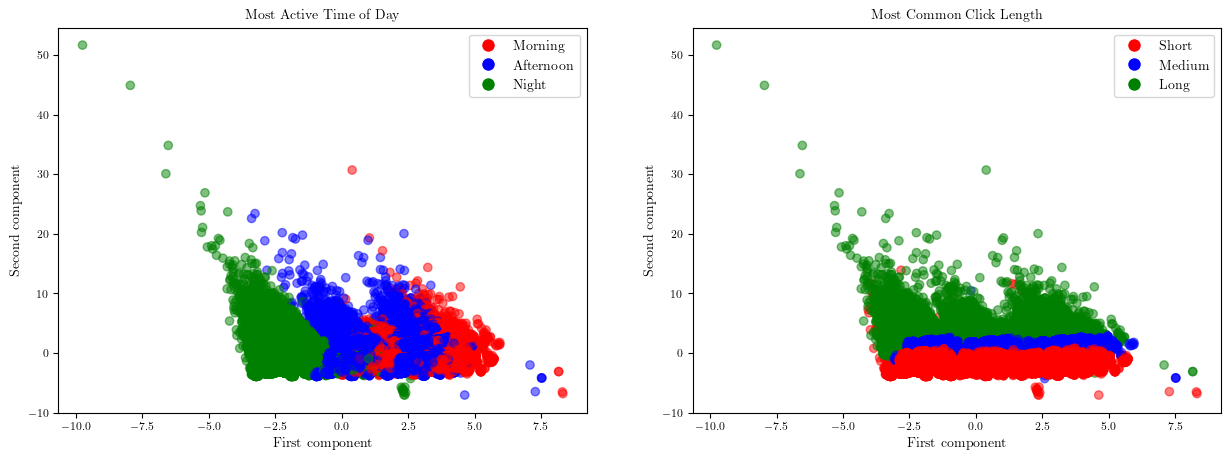

In [7]:
#Here we use the Plotter object to plot the principal components of the reduced dataset
#We plot by distinguishing the categories of the most_active_time_day column and most_common_click_length
Plotter().plot_principal_components(clustering_data, famd_df)


We can see that the **FAMD** top 2 principal components achieve some degree of separation of users when taking into account some of their features. Obviously there is still some overlap since we are only accounting for $\sim 5 \%$ of variance for the first component and $\sim 4 \%$ of variance for the second component. We can also observe that the first component captures more of the variance of the Most Active Time of Day in contrast with the second component that better captures the variance of the Most Common Click Length feature.

We can therefore observe we are effectively separating users with the help of the FAMD analysis we did before. Now it is time to use these new features to perform **clustering** and find groups of users depending on their behaviour on Netlix.

### **2.3. Clustering!**

As a first approach to perform clustering in our dataset we used the **k-Means** clustering algorithm. This algorithm is a centroid-based clustering technique that partitions the dataset into $k$ distinct clusters, where each data point belongs to the cluster with the **nearest** center. Mathematically, we have a set of $n$ points $\{\vec{x}_{1}, \dots, \vec{x}_{n}\}$, where each point is an $m$-dimensional vector and we would like to partition the data in $k$ clusters $\{C_{1}, \dots, C_{k}\}$ represented by their centroids $\{\vec{c}_{1}, \dots, \vec{c}_{k}\}$ in a way that minimizes the sum of squared distances from each point to its nearest centroid. 

The sum of squared distances (or **inertia**) is defined as follows:

\begin{equation*}
\text{Inertia} = \sum_{i=1}^{k} \sum_{\vec{x}\in C_{i}} ||\vec{x}-\vec{c}_{i}||^{2}
\end{equation*}

To do this, the k-Means algorithm by choosing $k$ initial centroids $\{\vec{c}_{1}, \dots, \vec{c}_{k}\}$ by randomly selecting $k$ data points from the dataset. Once these centroids are selected it alternates between the following steps (in the context of MapReduce):

1. **Mapping Step**: In this step, we **map** each data point to the cluster with the nearest centroid, i.e., the centroid with the least sum of squared distances. Mathematically this is:

    \begin{equation*}
    C_{i}^{(t)} = \left\{\vec{x} : ||\vec{x}-\vec{c}_{i}^{(t)}||^{2} \leq ||\vec{x}-\vec{c}_{j}^{(t)}||^{2} \quad \forall j, 1\leq j \leq k \right\}
    \end{equation*}

    where $C_{i}^{(t)}$ is the set of points that belong to cluster $i$ at iteration $t$ and $\vec{c}_{i}^{(t)}$ is the centroid of cluster $i$ at iteration $t$.

2. **Reduce Step**: For each cluster, we compute a new centroid by taking the mean of the data points assigned to that cluster. Mathematically this is:

    \begin{equation*}
    \vec{c}_{i}^{(t+1)} = \frac{1}{|C_{i}^{(t)}|}  \sum_{\vec{x}\in C_{i}^{(t)}}\vec{x}
    \end{equation*}

These two steps are repeated until the cluster assignments no longer change or a specified number of iterations has been reached.

We implemented this algorithm in the custom-made `KMeans` class contained in the `cluster.py` module of our repository by using the MapReduce paradigm (as mentioned before) using **PySpark**. To do this we performed the following steps

1. We first used the Spark `.parallelize()` method to **distribute** our data accross multiple nodes in order to process data simultaneously.

2. Then, we applied the **Mapping Step** and **Reduce Step** iteratively to each point distributed in different nodes and obtained a centroid update for each cluster.

3. If the new centroids don't change, we exit our algorithm and return the **total inertia** of our clusters and the labels of each pont.

As we can see, there is a crucial part of this algorithm that we still haven't talked about: how to choose the number of clusters $k$. There exist several methods to find an optimal number of clusters and in order to compare results, in this homework we will talk about two: **The Elbow Method** and **The Silhouette Score**.

#### **2.3.1. The Elbow Method**

The elbow method is a very intuitive technique used to determine the optimal number of clusters in a k-means clustering algorithm by plotting the **total inertia** of the algorithm for different values of $k$ and look for an *elbow* point on the graph. The *elbow* point can be defined as follows:

> A point on the plot where the **rate of decrease** in the inertia sharply changes, forming an elbow-like shape.

The idea behind this method is that adding more clusters beyond this point does not significantly reduce the inertia. In the end, inertia will always decrease when we increase $k$, so we're making a trade-off between a small number of clusters $k$ with the smallest inertia possible.

If we plot the total inertia for several values of $k$ we get:


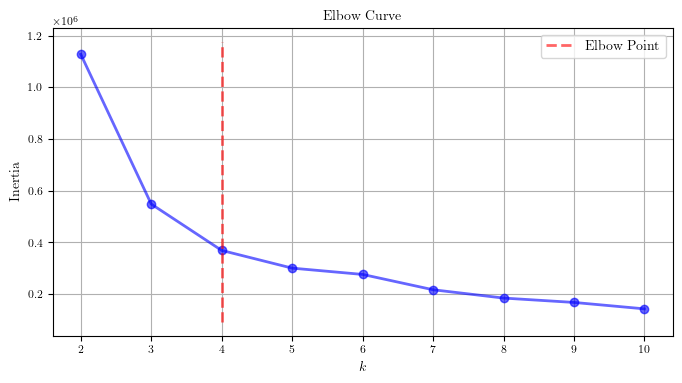

In [9]:
#Here we plot the elbow curve of the reduced dataset
Plotter().plot_elbow(famd_df.values)


As we can see, the **elbow** (we found this value using the `KneeLocator` class of a python package called `kneed`) of our inertia curve is found when $k=4$ since it is the value when the rate of decrease of inertia changes to a more constant way. This method suggests we should use $k=4$ clusters for our k-Means algorithm. Nevertheless, we can use another method to be sure of the number of clusters we can use: **The Silhouette Score**.

#### **2.3.2. The Silhouette Score**

The Silhouette Score is a metric that measures how well each data point in a dataset fits into its assigned cluster. It combines information about both the **cohesion** (how close a data point is to other points in its own cluster) and the **separation** (how far a data point is from points in other clusters) of the data point. Mathematically it is defined as:

\begin{equation*}
S = \frac{a-b}{\text{max}(a,b)},
\end{equation*}

where $a$ is the average distance between a data point and all the other points in its same cluster and $b$ is the average distance between a data point and all the other points in the next nearest cluster. A high Silhouette Score signifies that clusters are far away from its nearest cluster and that clusters are more well-defined.

The Silhouette Score has a range of $[-1, 1]$, from incorrect clustering to highly dense clustering, with 0 being overlapping clusters. Therefore, finding a **local** maximum in the Silhouette Score when varying $k$ can give us the optimal value of $k$ to perform $k$-Means clustering.

If we plot the Silhouette Score for several values of $k$ we get:

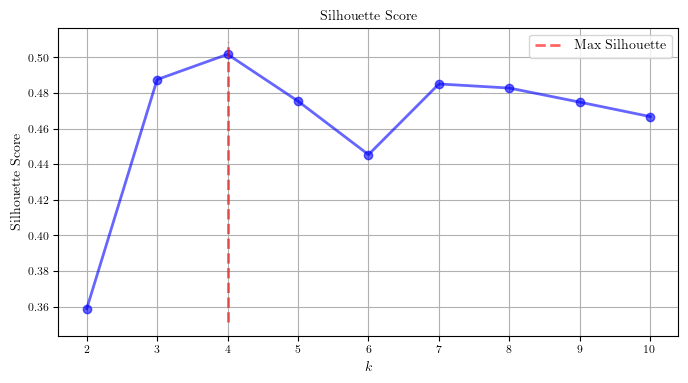

In [7]:
#Here we plot the silhouette score of the reduced dataset
Plotter().plot_silhouette(famd_df.values)


As we can see, also with this method we found that the optimal value of $k$ for our clustering algorithm is $k=4$ since is the value that gives us a (local) maximum of the Silhouette Score. Since the value for $k$ is the same for both our algorithms, we can proceed to perform our MapReduce k-Means algorithm with $k=4$.

#### **2.3.3. Running the k-Means algorithm**

We can run our k-Means algorithm by using the `fit()` method of our custom-made `KMeans` class included in our `cluster.py` module. For more information about the **implementation** of this class, please refer to this Python file.

In [7]:
#Here we initialize the k-Means class with k=4, a random state to reproduce the results and verbose=True to print the results
#Then we fit the k-Means model to the reduced dataset
kmeans = KMeans(k=4, random_state=42, verbose=True).fit(famd_df.values)
print(f"The total inertia of the k-Means model is {round(kmeans.inertia,2)}")


Convergence reached after 13 iterations
The total inertia of the k-Means model is 368664.91


As we can see our algorithm took $13$ iterations to converge to a solution and resulted in a total inertia of $\approx 368k$ which is a very high value but is the best around all values of $k$ as we've seen before. We can also observe the final centroids we obtained with our algorithm with respect to each cluster:

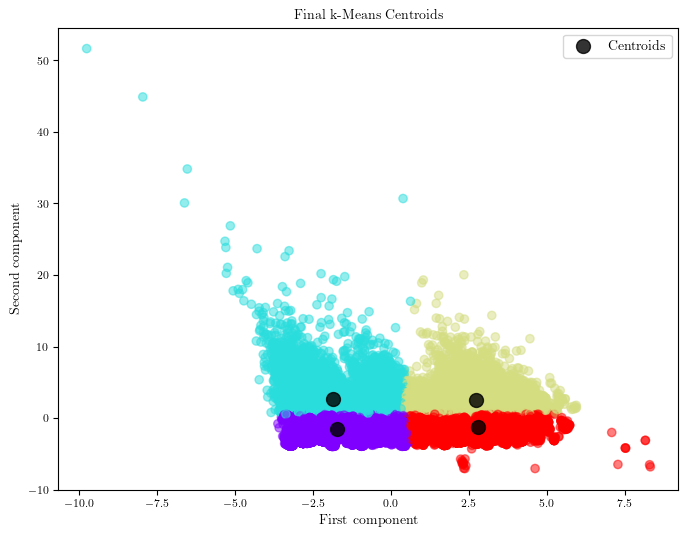

In [8]:
#Here we plot the centroids and the clustered data
Plotter().plot_centroids(famd_df.values, kmeans.centroids, kmeans.labels)


As we can observe, our k-Means algorithm effectively separated our data in 4 clusters, although with some degree of overlapping. As we've seen before, the Silhouette score of our clustering for $k=4$ is $S\approx 0.5$ which is a value that is halfway between incorrect clustering to highly dense clustering. We can therefore interpret our results as decent, since we achieved a reasonable clustering solution, but there is still room for improvement since we're still far from a highly dense clustering.

k-Means is a fast algorithm to find $k$ clusters in data but it is very *sensible* to the initial choice of the centroids, since these are taken at random from all the data points, this effectively means that we can find worse/better results depending on our initial *random* choice. Therefore it is better to perform a wiser way of initializing our centroids. We can achieve this using the **k-Means++ initialization**.

#### **2.3.4. k-Means++ Algorithm**

The k-Means++ algorithm specifies a procedure to initialize the cluster centroids before moving forward with the standard k-Means clustering algorithm. In this way, we are more likely to find a solution that is near to the **optimal** k-Means solution. The steps to initialize the centroids using k-Means++ are:

1. Similar to the original k-Means, the **first** cluster centroid $c_{1}$ is chosen uniformly at random from the data points $S$ that we want to cluster.

2. For each data point $x\in S$, we calculate the **minimum** squared distance between the data point $x$ and the centroids $\{c_{1}, \dots, c_{m}\}$ that have already been defined. Thus if centroids $\{c_{1}, \dots, c_{m}\}$ have already been chosen, we define $d_{m}(x) = \text{dist}^{2}(x, c_{j})$  where $j=h$, $1 \leq h \leq m$, for which $\text{dist}^{2}(x, c_{h})$ has the minimum value.

3. Finally, we choose one of the data points $x \in S - \{c_{1}, \dots, c_{m}\}$ at random as a new centroid where the probability of any data point being chosen is proportional to $d_{m}(x)$. Thus the probability that $x$ is chosen is equal to:
    $$\mathbb{P}(x) = \frac{d_{m}(x)}{ \sum_{z\epsilon S} d_{m}(z)}$$

    We repeat this algorithm until we have defined the $k$ centroids of our clusters and then we proceed with standard k-Means.

We can run our k-Mean++s algorithm by using the `fit()` method of our custom-made `KMeansPlusPlus` class included in our `cluster.py` module. For more information about the **implementation** of this class, please refer to this Python file.

In [9]:
#Here we initialize the k-Means++ class with k=4, a random state to reproduce the results and verbose=True to print the results
#Then we fit the k-Means model to the reduced dataset
kmeans_pp = KMeansPlusPlus(k=4, random_state=42, verbose=True).fit(famd_df.values)
print(f"The total inertia of the k-Means model is {round(kmeans_pp.inertia,2)}")


Convergence reached after 11 iterations
The total inertia of the k-Means model is 368664.91


As we can see our algorithm with the k-Means++ initialization took $11$ iterations to converge to a solution ($2$ iterations less than the standard k-Means) and resulted in a total inertia of $\approx 368k$ which is equal to the value we obtained previously with standard k-Means. So we can conclude that:

> We obtained the same results (considering inertia) by reducing the number of iterations since k-Means ++ initialization chooses as initial centroids separated points in order to don't define clusters very close to each other, resulting on less updates when trying to find the optimal centroids.

We can also observe the final centroids we obtained with our algorithm with respect to each cluster:

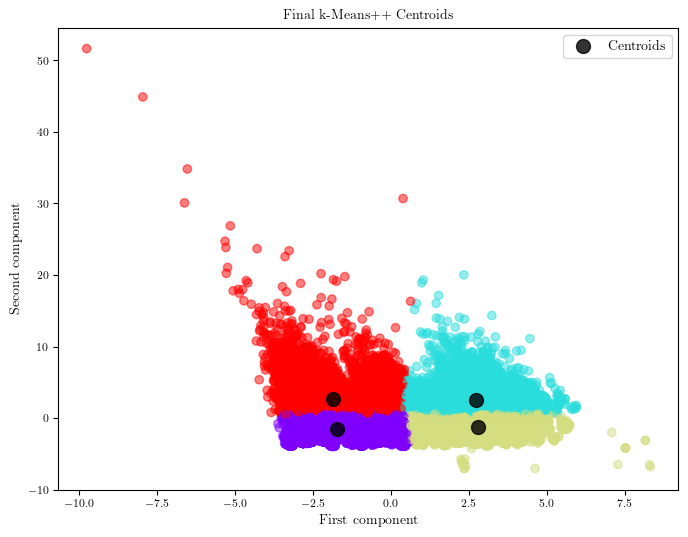

In [12]:
#Here we plot the centroids and the clustered data
Plotter().plot_centroids(famd_df.values, kmeans_pp.centroids, kmeans_pp.labels, "k-Means++")


#### **2.3.5. Bisecting k-Means Algorithm**

After performing clustering using k-Means and k-Means++, we asked ChatGPT to recommend other clustering algorithms in order to choose one and compare its results against the ones we obtained before. The prompt we wrote was: 

> Recommend 3 not-density-based clustering algorithms that are similar or variants to KMeans/KMeans++ clustering and are scalable to large datasets.

We asked specifically for non-density based clustering algorithms since the **Bonus** section already covers this type of algorithms and we wanted to compare our k-Means implementation with an algorithm similar to its implementation since density-based algorithms normally perform better with performance metrics like the Silhouette Score. We also asked for algorithms that are scalable to large datasets since as a first approach we tried to implement the **Mean Shift** algorithm and it was very computationally expensive, not leading results after a lot of iterations. The response we obtained by ChatGPT was:

>Sure, here are three clustering algorithms that are similar or variants to KMeans/KMeans++ and are scalable to large datasets:
>
>1. **MiniBatch KMeans**:
>
> - **Description:** MiniBatch KMeans is a variant of KMeans that uses randomly selected subsets, or mini-batches, of the dataset to update the cluster centroids instead of the entire dataset. This makes it computationally more efficient and suitable for large datasets.
> - **Advantages**:
>    
>    Faster convergence due to partial updates.
>    
>    Scalable to large datasets.
>
>    Can be more memory-efficient compared to traditional KMeans.
>
>2. **Mean Shift**:
>
> - **Description:** Mean Shift is a non-parametric clustering algorithm that doesn't require specifying the number of clusters beforehand. It works by shifting data points towards the mode (peak) of the data distribution. It is suitable for large datasets and doesn't rely on the Euclidean distance metric.
> - **Advantages**:
>    
>    No need to specify the number of clusters.
>    
>    Can handle irregularly shaped clusters.
>
>    Suitable for high-dimensional data.
>
>3. **Bisecting K-Means**:
>
> - **Description:** In Bisecting K-Means, the algorithm starts with the entire dataset as a single cluster and recursively bisects the cluster with the highest sum of squared distances (SSQ) into two clusters. This process continues until the desired number of clusters is reached. At each step, the bisected cluster is the one that results in the greatest reduction in SSQ.
> - **Advantages**:
>    
>    Hierarchical in nature, providing a tree-like structure of clusters.
>    
>    Can be effective in certain scenarios, especially when clusters have varying shapes and sizes.
>
>    Helps avoid local minima issues encountered by traditional K-Means.

These algorithms provide different approaches to clustering and have been shown to be scalable to large datasets, making them suitable alternatives to KMeans for specific use cases.

We chose to implement the **Bisecting k-Means** algorithm since we couldn't implement **Mean Shift** due to computational issues and **MiniBatch KMeans** is just the original k-Means by taking batches. **Bisecting k-Means** is a hybrid approach between [Divisive Hierarchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) and k-Means clustering. The key difference is that instead of partitioning the data set into $k$ clusters in each iteration, Bisecting k-Means splits one cluster into two sub clusters at each step (by using standard k-Means) until $k$ clusters are obtained. 

The algorithm for Bisecting k-Means works as follows:

1. We set all of our data in one single **cluster**.

2. We use the standard **k-Means** with $k=2$ to split this cluster into two clusters.

3. We obtain the **inertia** or intra-cluster distance for each cluster. This is, if we have $\{x^{(t)}_{1}, \dots, x^{(t)}_{n}\}$ elements in cluster $C_{t}$ (with centroid $c_{t}$), the intra-cluster distance is given by:

    $$d_{t} = \sum_{i=0}^{n} \left(x_{i}^{(t)}-c_{t}\right)$$

    Once we've obtained $d_{t}$ for every cluster, we select the cluster with the **highest** intra-cluster distance and split this cluster again using standard **k-Means** with $k=2$ .

4. We repeat step 3 until we've reached $k$ different clusters.

The following is a diagram of the procedure for this algorithm:

<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*-JqsJLWUPJtQWaH-ANBN5A.png" height=350 width=600>
</p>

In this case we separate the whole dataset in two clusters (A and B) using standard k-Means, then, at the same time, we separate A and B into the final clusters are C, D, E, and F. This is the result of the Bisecting 4-Means, since we obtained 4 different clusters.

We now, can implement the **Bisecting k-Means** algorithm to our data using the `sklearn` Python package:

In [46]:
bisect_kmeans = BisectingKMeans(n_clusters=4, random_state=42).fit(famd_df.values)
print(f"The total inertia of the k-Means model is {round(bisect_kmeans.inertia_,2)}")


The total inertia of the k-Means model is 368736.23


As we can see, the inertia is *slightly* higher than the inertia we obtained in our previous algorithms but nothing significant. We can observe the final centroids we obtained with our algorithm with respect to each cluster:

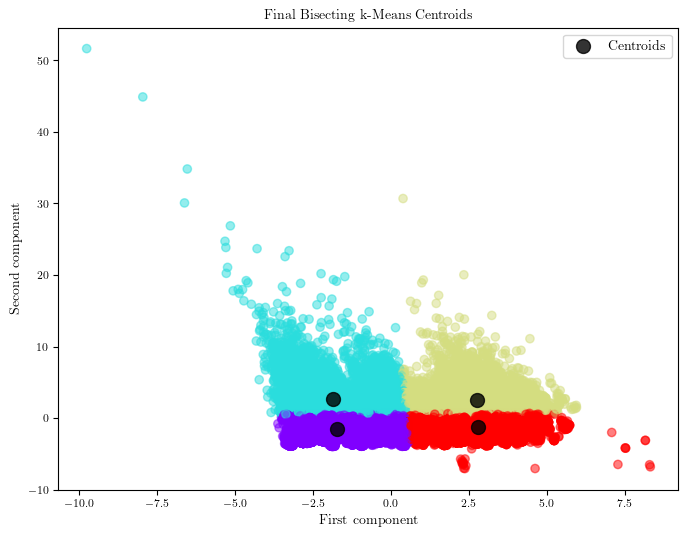

In [15]:
#Here we plot the centroids and the clustered data
Plotter().plot_centroids(famd_df.values, bisect_kmeans.cluster_centers_, bisect_kmeans.labels_, "Bisecting k-Means")


As we can see, we obtained similar results to the centroids obtained with k-Means and k-Means++. We also can compare these algorithms by obtaining their Silhouette Score defined in section 2.3.2 in order to quantify how good are the clusters we found using each algorithm.

It is important to note that obtaining the Silhouette Score has a time complexity of $O(n^{2})$ and therefore is very expensive when trying to compute it for large datasets. This is why we will compute it only in a *sample* of our dataset that is significant enough to yield good results.

Computing the Silhouette score:

In [23]:
#Here we compute the silhouette score of the k-Means model, the k-Means++ model and the Bisecting k-Means model
print(f"The silhouette score of the k-Means model is {round(silhouette_score(famd_df.values, kmeans.labels, sample_size=10000),2)}")
print(f"The silhouette score of the k-Means++ model is {round(silhouette_score(famd_df.values, kmeans_pp.labels, sample_size=10000),2)}")
print(f"The silhouette score of the Bisecting k-Means model is {round(silhouette_score(famd_df.values, bisect_kmeans.labels_, sample_size=10000),2)}")


The silhouette score of the k-Means model is 0.5
The silhouette score of the k-Means++ model is 0.5
The silhouette score of the Bisecting k-Means model is 0.5


In conclusion we can't say for sure which algorithm performed better in terms of **quality** of the clusters we found. Nevertheless we can note some important differences:

* Although **k-Means** is generally faster than **k-Means++** since it takes centroids at random, **k-Means++** takes **less** iterations to find the optimal clustering centroids since it generally starts from a better initial condition.

* Although **Bisecting k-Means** still has a random initialization by design, it will still be more computationally efficient than regular **k-Means** when $k$ is large since for **k-Means**, each computation involves every data point of the data set and $k$ centroids. On the other hand, in each step of **Bisecting k-Means**, only the data points of one cluster and two centroids are involved in the computation. Thus, the computation time is reduced.


Therefore we can conclude that there is a "better" algorithm depending the case, since for big values of $k$ it would be wise to implement **Bisecting k-Means** at the cost of random initialization, but when $k$ is not that big it would be better to use **k-Means++** since it is more robust to initial conditions. Definitely both of these algorithms are better than standard **k-Means** since they are generalizations that solve issues that the original **k-Means** had in the first place.

### **2.4. Analyzing our results!**

After analyzing the performance of several clustering algorithms with our dataset we can finally *characterize our clusters* in order to understand the reason why **users** are clustered in the way they are, in other words, understand the profile of the users in each of our clusters. To do this, we selected three **key** features of our dataset that can help us characterize our clusters:

1.  **Most Active Time of Day (Morning/Afternoon/Night)** (`most_active_time_day`): Let's remember that we classified each user depending on the moment of the day in which they spent more time on Netflix using the following rule:

    * If they spent more time between 4:00 a.m. and 11:59 p.m. they are classified as **Morning**.

    * If they spent more time between 12:00 p.m. and 19:59 p.m. they are classified as **Afternoon**.

    * If they spent more time between 20:00 p.m. and 3:59 a.m. they are classified as **Night**.

2. **Follow-Through-Probability (FTP)** (`ft_probability`): This feature gives us the probability that a user clicks on a movie and stays to watch. In order to characterize our clusters depending on this variable, we categorized values of this feature as follows:

    * If a user has a $FTP < 0.3$ we categorize its value as **Low**.

    * If a user has a $0.3 \leq FTP < 0.6$ we categorize its value as **Medium**.

    * If a user has a $FTP \geq 0.6$ we categorize its value as **High**.

    In this way we can obtain the percentage of users in our clusters that fall in each of these categories.

3. **Most Frequent Click Duration** (`most_common_click_length`): Let's remember that we classified each user depending on their most frequent **click length** by the following rule:

    * If their most frequent click duration was under **10 minutes** we classified as **Short** click.

    * If their most frequent click duration was between **10 minutes** and **1 hour** we classified as **Medium** click.

    * If their most frequent click duration was longer than **1 hour** we classified as **Long** click.

In order to characterize our clusters using these variables we built **pivot tables**, this is, tables that have he clusters we obtained with the **k-Means++** algorithm (we chose this algorithm since it is the one that has more robust results) on the horizontal axis, and on the vertical axis, the categories of each variable. To build these tables we used our `DataHandler` class we defined earlier in this notebook:


In [7]:
#First, we add the labels of the k-Means++ model to the original clustering dataset
clustering_data['cluster'] = kmeans_pp.labels

#Here we obtain the pivot table for the most_active_time_day column
most_active_time_day_pivot = data_handler.pivot_table(clustering_data, 'most_active_time_day')
#Here we obtain the pivot table for the most_common_click_length column
most_common_click_length_pivot = data_handler.pivot_table(clustering_data, 'most_common_click_length')
#Here we obtain the pivot table for the ft_probability column
ft_probability_pivot = data_handler.pivot_table(clustering_data, 'ft_probability')


We can observe the first pivot table for the **Most Active Time of Day** feature:

In [11]:
#Here we print the first pivot table
most_active_time_day_pivot


most_active_time_day,Afternoon,Morning,Night
cluster,,,
0,21.571269,0.439799,77.988932
1,71.574412,28.266367,0.159221
2,71.835845,27.492283,0.671872
3,21.329033,0.383375,78.287592


As we can see this feature segments our clusters (and the users within them) in two **main** categories:

1. Users that usually spend more time watching Netflix between 20:00 p.m. and 3:59 a.m. are more represented ($\approx 80\%$) in **Cluster 0** and **Cluster 3**. Therefore we can conclude that users within these clusters prefer watching movies/series until high hours of the night (probably they are what's known as *night owls*) in contrast with the other clusters.

2. Users that usually spend more time watching Netflix between 12:00 p.m. and 19:59 p.m. are more represented ($\approx 70\%$) in **Cluster 1** and **Cluster 2**. Therefore we can conclude that users within these clusters prefer watching movies/series in the afternoon but they don't spend that much time when the night comes. There could be several reasons for this like: age, which device they are watching on, etc.

It would be interesting to know more information about these clusters to see what other behaviours we can obtain from our clustering. If we observe the second pivot table, for the **Follow-Through-Probability** feature:

In [39]:
#Here we print the second pivot table
ft_probability_pivot


ft_probability_class,High,Low,Medium
cluster,,,
0,4.219478,65.218520,30.562002
1,77.858949,0.341856,21.799195
2,4.443695,64.868090,30.688215
3,76.443741,0.547678,23.008580


As we can see, in the same way as before, this feature segments our clusters (and the users within them) in two **main** categories:

1. Users that have a **high** Follow-Through Probability (bigger than $0.6$) are more represented ($\approx 80\%$) in **Cluster 1** and **Cluster 3**, which means that the probability that users in these clusters click in a movie and stay to watch it is bigger than $60\%$. We can conclude from this that users within these clusters are more direct and know exactly what they like beforehand.

2. On the other side, users that have a **low** Follow-Through Probability (lower than $0.3$) are more represented ($\approx 70\%$) in **Cluster 0** and **Cluster 2**, which means that the probability that users in these clusters click in a movie and stay to watch it is lower than $30\%$. We can conclude from this that users within these clusters are indecisive and although they click on movies they generally don't watch them.

Finally, we can observe the distribution of the users for our clusters for the final feature: the **Most Frequent Click Duration**:

In [40]:
#Here we print the third pivot table
most_common_click_length_pivot


most_common_click_length,Long,Medium,Short
cluster,,,
0,1.965303,1.639105,96.395592
1,84.579002,12.695514,2.725485
2,1.779553,1.966329,96.254118
3,86.825291,8.851092,4.323617


As we can see, this feature is tightly correlated with the Follow-Through probability, since this feature segments our clusters (and the users within them) in the same two **main** categories:

1. Users that have a **Long** Click Duration (bigger than 1 hour) are more represented ($\approx 90\%$) in **Cluster 1** and **Cluster 3**, which means that it is $90\%$ probable that users within these clusters click on a movie and remain within it for at least one hour. These groups are similar as the last ones we found: people that normally decide quickly what they want to watch.

2. On the other side, users that have a **Short** Click Duration (lower than 10 minutes) are more represented ($\approx 90\%$) in **Cluster 0** and **Cluster 2**, which means that it is $90\%$ probable that users within these clusters click on a movie and exit before 10 minutes have passed. We can conclude from this that users within these clusters are indecisive and they click in a lot of movies before remaining in one.

With the understanding of how our users are distributed within our clusters we can conclude the following:

1. **Cluster 0** is formed by users that are more active during the **night** and usually they have a **low** probability on watching movies for more than 10 minutes. Therefore we can characterize this cluster as users that click a lot of movies during the night but hardly watch them until the end.

2. **Cluster 1** is formed by users that are more active during the **afternoon** and usually they have a **high** probability on watching movies for more than 1 hour. Therefore we can characterize this cluster as users that have high activity before the night and usually watch the movies until the end.

3. **Cluster 2** is formed by users that are more active during the **afternoon** and usually they have a **low** probability on watching movies for more than 10 minutes. Therefore we can characterize this cluster as users that click a lot of movies during the afternoon but hardly watch them until the end.

4. **Cluster 3** is formed by users that are more active during the **night** and usually they have a **high** probability on watching movies for more than 1 hour. Therefore we can characterize this cluster as users that watch complete movies during the night without skipping them constantly.

We can conclude that our clustering was successful in separating users that are very active during the day/night and that have high/low probabilities of clicking on a movie and remaining in it.

#### **2.4.1. Performance of our Algorithms**

Finally, in order to estimate the performance of our clustering algorithms (how good are the clusters we found) we will use the Calinski-Harabasz Index. This index measures the between-cluster dispersion against within-cluster dispersion. A higher score signifies better-defined clusters. Mathematically it is defined as:

\begin{equation*}
CBS = \frac{B}{W} \cdot \frac{n_{E}-k}{k-1},
\end{equation*}

where $B$ is the between-cluster dispersion, $W$ is the within-cluster dispersion, $n_{E}$ is the number of data points and $k$ is the number of clusters.

If we obtain it for all the algorithms we've defined before, we have that:



In [47]:
#Here we compute the Calinski-Harabasz score of the k-Means model, the k-Means++ model and the Bisecting k-Means model
print(f"The Calinski-Harabasz score of the k-Means model is {round(calinski_harabasz_score(famd_df.values, kmeans.labels),2)}")
print(f"The Calinski-Harabasz score of the k-Means++ model is {round(calinski_harabasz_score(famd_df.values, kmeans_pp.labels),2)}")
print(f"The Calinski-Harabasz score of the Bisecting k-Means model is {round(calinski_harabasz_score(famd_df.values, bisect_kmeans.labels_),2)}")


The Calinski-Harabasz score of the k-Means model is 184682.66
The Calinski-Harabasz score of the k-Means++ model is 184682.66
The Calinski-Harabasz score of the Bisecting k-Means model is 184637.07


As we can see, there is no significant difference before our three clustering approaches. Nevertheless in order to characterize how good our clusters are, we can resort again to the **Silhouette Score** since, as we know, gives us a bounded measure of how well-separated the clusters are. In particular, it quantifies the similarity of an object to its own cluster (cohesion) compared to other clusters (separation). We can segment the Silhouette Score values in three categories:

* **Close to +1**: Indicates that data points are well inside their own cluster and far from neighboring clusters.

* **Around 0**: Indicates that data points are very close to the decision boundary between two neighboring clusters.

* **Close to -1**: Indicates that tdata points may have been assigned to the wrong cluster.

Since we obtained a Silhouette Score of $\approx 0.5$ for all of our clustering algorithms we can conclude that, on average, our clusters are well-defined and sufficiently separated but are not very compact. Nevertheless as we've seen before, we did segment our users in meaningful well defined groups.

**References for this section:**

1. [Introduction to MapReduce](https://medium.com/@devparmar967/introduction-to-mapreduce-4d37712da879).
2. [K-Means Clustering](https://medium.com/ai-made-simple/k-means-clustering-e9bd722a09fa).
3. [Understanding Principal Component Analysis](https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0).
4. [Factor Analysis of Mixed Data](https://towardsdatascience.com/factor-analysis-of-mixed-data-5ad5ce98663c)
5. [How to Determine the Optimal K for K-Means?](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb).
6. [7 Evaluation Metrics for Clustering Algorithms](https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2#5f41).
7. [Bisecting Kmeans Clustering](https://medium.com/@afrizalfir/bisecting-kmeans-clustering-5bc17603b8a2).

----

## **4. Command Line Question (CLQ)**

In this question, we used the command line and its tools to answer some questions regarding our original dataset. To do this, we created an executable **bash** script called `commandline.sh` where we parse and manipulate our original dataset in order to obtain relevant information. For questions about the **implementation** of this script please refer to the file included in the repository.

The questions we need to answer are the following:

1. What is the most-watched Netflix title?

2. Report the average time between subsequent clicks on Netflix.com

3. Provide the ID of the user that has spent the most time on Netflix

For the first and second questions we used standard `cut`, `tail`, `sort`, `uniq`, `head` and `awk` commands to obtain the answers. On the other side, in the **third** question we encountered a problem that was not easy to avoid:

> Since our csv values are comma-separated, when we try to parse the csv after the *genres* column, common bash tools aren't enough since they can't distinguish between the commas inherent to the string values of a column and the column itself.

Therefore, to solve this question and avoid this problem we used a command-line tool that wasn't previously installed but resulted very useful in parsing our csv file. This tool is called `csvkit`. For more information about the tool please visit its [documentation](https://csvkit.readthedocs.io/en/latest/).

In the end, we can our final bash script as follows:

In [28]:
#Here we run our commandline script
! ./commandline.sh


The most-watched Netflix title is:  Black Mirror: Bandersnatch
sort: Broken pipe
The average time (in seconds) between subsequent clicks on Netflix is: 33476
The ID of the user that has spent the most time on Netflix is:  322abe045c
sort: Broken pipe


As we can see, we obtained a `sort: Broken pipe` warning. According to this [source](https://stackoverflow.com/questions/46202653/bash-error-in-sort-sort-write-failed-standard-output-broken-pipe):

> `sort | head` always reports an error, if head exits before sort has written all its output (as will be the case, if the stream written by sort is much longer than that consumed by head). 

However, this error doesn't affect the output whatsoever so we decided to ignore it. Nevertheless it is important to note that this error didn't appear when running our bash script on our local terminal, this could mean that this error may not be reported in all bash instances. We can see in the following screenshot our final result:

<p align="center">
<img src="images/commandline_output.png" height=150 width=700>
</p>

----

## **5. Algorithmic Question (AQ)**

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate,  but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system. 

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part.
He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:
+ If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S - p$.
+ If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p - S$.

So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5 < 8$ and $8 - 5 = 3$, the remaining list now becomes $[10,4]$, and his score is updated as $S = 5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line,  and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get. 

### **5.1. First Approach: Recursive Algorithm**

As was hinted in the problem statement, we can attack this problem by writing a **recursive algorithm** that finds the maximum possible score by recursively comparing the score values for all possible mark combinations that Francesco can obtain. Our algorithm is written as follows:

In [32]:
def highest_score(S: int, marks_list: list) -> int:
    """
    Function that returns the highest score that can be achieved by taking exams

    Args:
        S (int): The starting score
        marks (list): The list of marks for each exam

    Returns:
        int: The highest score that can be achieved
    """
    #This is our base case, if there are no exams left to take, we return the score S
    if len(marks_list) == 0:
        return S

    #Here we initialize the maximum score to -infinity since we'll be comparing it with the scores of each exam
    max_score = -np.inf

    #Here we iterate through all the marks of the exams
    for i in range(len(marks_list)):
        #For each iteration we take the score of the exam
        p = marks_list[i]
        #And we make our new score the value of the score of the exam
        new_score = p
        #Once we've done this, the scoring system changes as follows:
        #If p < S, then we the mark of all the other exams is increased by S-p
        if p < S:
            #Here we ensure that the new marks list doesn't contain the mark of the exam we just took
            new_marks = [mark + (S - p) for mark in marks_list[:i] + marks_list[i+1:]]
        #If p >= S, then we the mark of all the other exams marks are decreased by p-S
        else:
            #Here we ensure that the new marks list doesn't contain the mark of the exam we just took
            new_marks = [mark - (p - S) for mark in marks_list[:i] + marks_list[i+1:]]
        
        #Finally, we update the maximum score by taking the maximum between the current maximum score 
        #and the highest score that can be achieved by taking a set of exams with the new score and the new marks
        #This is done recursively until we reach the base case for all the possible combinations of exams
        max_score = max(max_score, highest_score(new_score, new_marks))

    #Finally, we return the overall maximum score
    return max_score


Here we can test the performance of our algorithm by inputting our testing cases. For the first example:

In [33]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 8
#Here we define the list of marks for each exam
marks = [5, 7, 1]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 11 and it took 0.0 seconds to run the algorithm


For the second example:

In [34]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 25
#Here we define the list of marks for each exam
marks = [18, 24, 21, 32, 27]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 44 and it took 0.0 seconds to run the algorithm


For the third example:

In [35]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 30
#Here we define the list of marks for each exam
marks = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 205 and it took 563.56 seconds to run the algorithm


As we can see our running time increased significantly with $n=12$ exams in our marks list. This comes from the recursive nature of our algorithm and its *potentially* exponential time complexity. Let's prove this formally.

#### **5.1.1. Time Complexity**

1. **Base Case:** The base case and max score initialization steps have **constant** time complexity since they involves a simple check on the length of the marks list and a simple variable initialization.

2. **For Loop Over Exams:** The iteratation through all the exams in the marks_list has a time complexity of $O(n)$, where $n$ is the number of exams since by definition, we have to loop through each element of the list.

3. **Operations Inside the Loop:**

    * **List Slicing and Concatenation:** In each iteration, the algorithm performs list slicing and concatenation to create the new_marks list. The slicing and concatenation operations take $O(n)$ time in the worst case.

    * **Constant Operations:** All variable assignments are made in **constant** time.

    * **Recursion:** In this step, the algorithm calls itself **recursively** with the new_score and new_marks variables. This step in the worst case scenario has time complexity of $O(2^{n})$. We'll elaborate later on this. 

4. **Max Operation:** The algorithm uses the max function to update the max_score with the maximum between the current max_score and the result of the recursive call. This operation takes constant time $O(1)$ since it involves comparing two numbers.

Now, for the **overall** time complexity, we can now consider that within the **for** loop the exponential recursion time complexity $O(2^{n})$ dominates all the other operations since it is bigger than the linear time complexity it takes to perform list operations.

On the other side, we will perform recursivity for **each** element on our marks list. Therefore the **overall** time complexity of our algorithm is:
$$\boxed{O(n\cdot 2^{n})}$$

Now, let's elaborate on why the Recursion step has time complexity of $O(2^{n})$. Let's consider that for each exam, our algorithm always explores two possibilities: either we add a number the current exam score or we subtract from it, this leads to a binary tree-like structure where we have $2^{n}$ leaves corresponding to each recursive call.

Now, we need to achieve a **better performance** of our algorithm by optimizing its time complexity. In order to do this we performed a **Dynamic Programming** approach.

### **5.2. Second Approach: Dynamic Programming**

**Dynamic Programming** is an optimization technique for solving recursive functions that make repeated calls to the same inputs. Dynamic programming works by breaking down complex problems into simpler subproblems and finding optimal solutions to these subproblems (in this case the subproblems are finding the score for a given score and list combination).

It does this by performing **memorization**. Memorization is a method that saves the outcomes of each of these processes so that the corresponding answers do not need to be computed when they are later needed. Saving solutions save time on the computation of subproblems that have already been encountered. 

As we can see from our algorithm, we are making unnecessary recursion steps by searching every time for the solution for a given combination of score $S$ and marks list $m$. Therefore, by performing memorization we can effectively reduce the times we call our recursive function since we can save its output and obtain it every time it is necessary.

The advantage of this optimization techinque is that it can be [shown](https://www.youtube.com/watch?v=OQ5jsbhAv_M) that its overall time complexity is given by:

$$T(n) = \text{Number of Recursive Function Calls} \times \text{Work Done per Recursive Function Call}$$

Applying this technique to our algorithm we obtain a new approach:

In [53]:
def highest_score_memorization(S: int, marks:list)-> int:
    """
    Function that returns the highest score that can be achieved by taking exams using memorization

    Args:
        S (int): The starting score
        marks (list): The list of marks for each exam

    Returns:
        int: The highest score that can be achieved
    """
    #Here we initialize the memorization dictionary in order to store the results of the subproblems
    memorization_dict = {}
    
    def subproblem(current_score: int, remaining_marks: list)-> int:
        """
        Function that returns the highest score that can be achieved by taking exams

        Args:
            current_score (int): The current score
            remaining_marks (list): The list of marks for each exam

        Returns:
            int: The highest score that can be achieved
        """
        #This is our base case, if there are no exams left to take, we return the score S
        if len(remaining_marks) == 0:
            return current_score

        #Now we sort the remaining marks in order to ensure that the subproblems are unique
        remaining_marks.sort()
        
        #Here we check if the subproblem has already been solved, if it has, we return the result
        #We use a tuple of the score and the marks list as the key of the memorization dictionary
        #This is done since tuples are hashable and can be used as keys in dictionaries
        if (current_score, tuple(remaining_marks)) in memorization_dict:
            return memorization_dict[(current_score, tuple(remaining_marks))]

        #Here we initialize the maximum score to -infinity since we'll be comparing it with the scores of each exam
        max_score = -np.inf

        #Here we iterate through all the marks of the exams
        for i in range(len(remaining_marks)):
            #For each iteration we take the score of the exam
            p = remaining_marks[i]
            #And we make our new score the value of the score of the exam
            new_score = p
            #Once we've done this, the scoring system changes as follows:
            #If p < S, then we the mark of all the other exams is increased by S-p
            if p < current_score:
                #Here we ensure that the new marks list doesn't contain the mark of the exam we just took
                new_marks = [mark + (current_score - p) for mark in remaining_marks[:i] + remaining_marks[i+1:]]
            #If p >= S, then we the mark of all the other exams marks are decreased by p-S
            else:
                #Here we ensure that the new marks list doesn't contain the mark of the exam we just took
                new_marks = [mark - (p - current_score) for mark in remaining_marks[:i] + remaining_marks[i+1:]]

            #Here we recursively call the function with the new score and the new marks
            max_score = max(max_score, subproblem(new_score, new_marks))

        #Here we update the memorization dictionary with the result of the subproblem
        memorization_dict[(current_score, tuple(remaining_marks))] = max_score
        return max_score

    #Here we return the result of the subproblem with the starting score and the marks list
    return subproblem(S, marks)

Here we can test the performance of our algorithm by inputting our testing cases. For the first example:

In [56]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 8
#Here we define the list of marks for each exam
marks = [5, 7, 1]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score_memorization(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 11 and it took 0.0 seconds to run the algorithm


For the second example:

In [55]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 25
#Here we define the list of marks for each exam
marks = [18, 24, 21, 32, 27]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score_memorization(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 44 and it took 0.0 seconds to run the algorithm


For the third example:

In [54]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 30
#Here we define the list of marks for each exam
marks = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = highest_score_memorization(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 205 and it took 0.37 seconds to run the algorithm


As we can see we've notoriously improved the running time of our algorithm. Moreover we have shown that this approach already includes a way of computing the time complexity of our algorithm based in Dynamic Programming. Let's see what this is.

#### **5.2.1. Time Complexity**

To analyze the time complexity of our new  algorithm, we have to look at the number of unique **subproblems** that are solved and how many times each subproblem is solved.

The number of subproblems in our algorithm is determined by the unique combinations of $S$ and the sorted marks list values. In the worst case, we can notice that this number is $n \cdot |S|$, where $|S|$ is the length of the range of possible values for $S$. This number in the worst case happens when the range of possible scores is proportional to the size of the input.

Now, knowing this, we can notice that in our algorithm the following process is followed:

>For each call to the `subproblem` function, there is a loop that iterates over the remaining marks ($n$ iterations). For each iteration of the loop, a recursive call to `subproblem` is made with a reduced set of remaining marks. The memorization table we built helps to avoid redundant computations, and if a subproblem has already been solved, its result is retrieved in constant time (by a call to our dictionary). 

As we've seen before, we can obtain the time complexity of this algorithm by the following formula:

$$T(n) = \text{Number of Recursive Function Calls} \times \text{Work Done per Recursive Function Call}$$

We've already obtained the number of recursive function calls since it is the same as the number of subproblems in our algorithm, given by $n \cdot |S|$. On the other side, we can observe that the work that takes to solve each subproblem is dominated by the loop iterating over the remaining marks (with time complexity $O(n)$). Therefore, the **overall** time complexity for our algorithm is given by:

$$T(n) = O(n \cdot |S|) \cdot O(n) = O(n^{2}\cdot |S|)$$

As we can see this is still a high time complexity but we've managed to avoid the exponential time our previous algorithm had before.

### **5.3. Third Approach: ChatGPT's Approach**

In order to find another approach to this problem we designed a prompt to ask ChatGPT by trying to enforce it to find an answer that has near-linear time complexity. Our prompt is:

>You're a Computer Scientist. Write an algorithm that solves the following problem:
>
>A student is given an initial score S (int) and a list of marks (integers) of exams he has to take. Once he chooses an exam, his score S becomes equal to the mark p of the exam he chose.
>
>If p<S, then we increase every element in the marks list by the quantity S-p (the list should not contain the chosen exam anymore)
>
>If p>=S, then we decrease every element in the marks list by the quantity p-S (the list should not contain the chosen exam anymore)
>
>The student wants to obtain the maximum possible score he can get after taking all the exams.
>
>Make sure your algorithm has an optimal time complexity.

We obtained the following response:

The response was as follows:

>To solve this problem, we can use a greedy algorithm. The idea is to sort the list of marks in descending order and iteratively choose the exams with the highest marks. For each chosen exam, we update the score and adjust the remaining exams accordingly based on the given conditions.
>
>Here's the algorithm in Python:
>
>```python
>def max_score(initial_score, marks):
>    # Sort the marks in descending order
>    marks.sort(reverse=True)
>    
>    # Iterate through the sorted marks
>    for mark in marks:
>        if mark < initial_score:
>            # Increase every element in the marks list by the quantity (initial_score - mark)
>            initial_score += (initial_score - mark)
>        else:
>            # Decrease every element in the marks list by the quantity (mark - initial_score)
>            initial_score -= (mark - initial_score)
>    
>    return initial_score
>
># Example usage:
>initial_score = 50
>marks = [70, 60, 80, 40, 90]
>result = max_score(initial_score, marks)
>print("Maximum possible score:", result)
>```
>
> This algorithm has a time complexity of $O(n log n)$ due to the sorting operation, where $n$ is the number of exams. The greedy strategy ensures that we always choose the exam that maximizes the score at each step.

First of all we may notice that the overall time complexity of this algorithm is $O(n)$ in the worst case since when sorting in the worst case we just need to move all elements in our list and the for loop has also time complexity of $O(n)$.

Now we can chat GPT's approach:

In [64]:
def max_score(initial_score, marks):
    # Sort the marks in descending order
    marks.sort(reverse=True)
    
    # Iterate through the sorted marks
    for mark in marks:
        if mark < initial_score:
            # Increase every element in the marks list by the quantity (initial_score - mark)
            initial_score += (initial_score - mark)
        else:
            # Decrease every element in the marks list by the quantity (mark - initial_score)
            initial_score -= (mark - initial_score)
    
    return initial_score


For the first example:

In [65]:
#Here we test our function with the first example given in the assignment
#Here we define the starting score
S = 8
#Here we define the list of marks for each exam
marks = [5, 7, 1]

#Here we start our timer to time the execution of the algorithm
start_time = time.time()
#Here we run our algorithm
result = max_score(S, marks)
#Here we stop our timer
end_time = time.time()

#Finally, we print the result and the time it took to run the algorithm
print(f"The highest score that can be achieved is {result} and it took {round(end_time - start_time, 2)} seconds to run the algorithm")

The highest score that can be achieved is 25 and it took 0.0 seconds to run the algorithm


We can see that the proposed algorithm is **wrong** since it gives a maximum possible score of 25 even though the real maximum possible score is 11.

We can conclude that even though the algorithm seems *simple* in principle, it is really challenging and it is difficult for a LLM to generalize for this kind of problem. We tried to prompt ChatGPT with different problem statements in order to get a better result but we failed every time.

**References for this section:**

1. [DP is Easy! (part 2)](https://medium.com/@timpark0807/dp-is-easy-part-2-74422931dd98)